In [1]:
import pandas as pd
import numpy as np

In [2]:
import torch

In [ ]:
tv = torch.__version__
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-"$tv".html
!pip install biopython

Looking in links: https://data.pyg.org/whl/torch-2.2.1+cu121.html


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GCNConv, GATConv, global_mean_pool
from torch_geometric.data import Data, Dataset
from torch_geometric.data import NeighborSampler
import torch_geometric.transforms as T
from torch_cluster import random_walk
import torch.optim as optim

import os
import numpy as np
from tqdm import tqdm
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
# Mention dataset, bin count and version for experiment
# Note: bin_count is only applicable for simulated datasets. For real datasets, it is assigned to None.
dataset = 'simlord'
bin_count = 10
version = 2

bins = bin_count if dataset == 'simlord' else None

In [ ]:
result_path = f"/content/drive/MyDrive/FYP/FYP/datasets/{dataset}{'/bin_'+str(bins) if bins != None else ''}/v{version}"
result_path

In [ ]:
os.listdir(result_path)

In [ ]:
truth_ = np.array(open(f"{result_path}/ground_truth.txt").read().strip().split("\n"))
truth_original = np.array(open(f"{result_path}/truth.txt").read().strip().split("\n"))

data = np.load(f'{result_path}/data.npz')

In [ ]:
weight_df = pd.read_csv(f"{result_path}/simlord_with_kraken_weights.csv")
sample_weights = weight_df['weight_standardized'].values

In [ ]:
def get_idx_maps(read_ids_file_path, truth):
    reads_truth = {}
    read_id_idx = {}
    # global read_id_idx
    with open(read_ids_file_path) as read_ids_file:
        for t, rid in tqdm(zip(truth, read_ids_file)):
            rid = rid.strip().split()[0][1:]
            reads_truth[rid] = t
            read_id_idx[rid] = len(read_id_idx)

    return reads_truth, read_id_idx


In [ ]:
reads_truth_, read_id_idx_ = get_idx_maps(f"{result_path}/read_ids", truth_)

In [ ]:
all(np.array(list(reads_truth_.values())) == truth_)

In [ ]:
edges_ = data['edges']
comp_ = data['scaled']

In [ ]:
comp_ = torch.from_numpy(comp_).float()

In [ ]:
idx = np.where(truth_ != '__None')[0]
idx.shape

In [ ]:
truth = truth_[idx]
comp = comp_[idx]
read_id_idx = np.array(list(read_id_idx_.items()))[idx]
reads_truth = np.array(list(reads_truth_.items()))[idx]

In [ ]:
id_list = read_id_idx[:,1]
id_list

In [ ]:
edges_.shape

In [ ]:
# mask = np.isin(edges_[:,0], id_list) & np.isin(edges_[:,1], id_list)
# mask.shape

In [ ]:
# edges = edges_[mask]
edges = edges_
edges.shape

In [ ]:
edge_index = torch.tensor(edges, dtype=torch.long)
edge_index.shape

In [ ]:
mask_unk = truth == 'unknown'
truth[mask_unk] = truth_original[mask_unk]

In [ ]:
def get_train_data(truth):
    lb = LabelEncoder()
    lb.fit(truth)

    y = lb.transform(truth)
    y = torch.tensor(y, dtype=torch.long)

    no_classes = len(set(truth))

    return y, no_classes, lb

y, no_classes, encoder = get_train_data(truth)

In [ ]:
no_classes

In [ ]:
train_idx = np.load(f"{result_path}/train_indices_{dataset}_v{version}.npy")
test_idx = np.load(f"{result_path}/test_indices_{dataset}_v{version}.npy")
train_idx.shape, test_idx.shape

In [ ]:
train_idx, val_idx, weight_idx_train, weight_idx_val = train_test_split(train_idx, np.arange(len(train_idx)), test_size=0.1, random_state=42)
train_idx.shape, val_idx.shape, weight_idx_train.shape, weight_idx_val.shape

In [ ]:
sample_weights_train = sample_weights[weight_idx_train]
sample_weights_val = sample_weights[weight_idx_val]
sample_weights_train.shape, sample_weights_val.shape

In [ ]:
def get_graph_data(features, edges,y,train_idx,test_idx,val_idx):
    edge_index = torch.tensor(edges, dtype=torch.long)
    edge_index = edge_index.t().contiguous()

    train_indices = torch.tensor(train_idx, dtype=torch.long)
    test_indices = torch.tensor(test_idx, dtype=torch.long)
    val_indices = torch.tensor(val_idx, dtype=torch.long)

    data = Data(x=features, edge_index=edge_index, y=y)

    train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

    train_mask[train_indices] = True
    test_mask[test_indices] = True
    val_mask[val_indices] = True

    data.train_mask = train_mask
    data.test_mask = test_mask
    data.val_mask = val_mask

    return data

data = get_graph_data(comp, edges,y,train_idx,test_idx,val_idx)

In [ ]:
data

In [ ]:
best_acc = 0

In [ ]:
def train_node_classifier(model, graph, optimizer, criterion, n_epochs=200):
    train_losses = []
    val_losses = []

    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        weighted_train_loss = torch.mean(loss * torch.tensor(sample_weights_train))
        weighted_train_loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        acc = eval_node_classifier(model, graph, graph.val_mask)

        val_loss = criterion(out[graph.val_mask], graph.y[graph.val_mask])
        weighted_val_loss = torch.mean(val_loss * torch.tensor(sample_weights_val))

        train_losses.append(weighted_train_loss.item())
        val_losses.append(weighted_val_loss.item())


        weighted_train_loss_np = weighted_train_loss.detach().numpy()
        weighted_val_loss_np = weighted_val_loss.detach().numpy()

        if epoch % 1 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {weighted_train_loss_np:.4f}, Val Acc: {acc:.4f}, Val Loss: {weighted_val_loss_np:.4f}')

        if epoch % 10 == 0:
            print(eval_node_classifier(model, graph, graph.test_mask))

        if acc > 0.995:
            break

    return model, train_losses, val_losses


def eval_node_classifier(model, graph, mask):
    model.eval()
    pred = model(graph).argmax(dim=1)
    correct = (pred[mask] == graph.y[mask]).sum()
    acc = int(correct) / int(mask.sum())
    return acc

In [ ]:
class GNNModel(torch.nn.Module):
    def __init__(self, in_channels, out_channels, num_layers, device):
        super(GNNModel,self).__init__()

        self.num_layers = num_layers
        # hidden_channels = (in_channels + out_channels)//2
        hidden_channels = 128

        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

        self.fc1 = torch.nn.Linear(hidden_channels, hidden_channels//2)
        self.fc2 = torch.nn.Linear(hidden_channels//2, out_channels)

        self.device = device

        self.to(device)

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = x.to(self.device)
        edge_index = edge_index.to(self.device)

        # print(x.shape, edge_index.shape)

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_layers = 2

In [ ]:
model = GNNModel(data.x.shape[1], no_classes, num_layers, device)

In [ ]:
criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=10e-6)

In [ ]:
data.to(device)

In [55]:
history = train_node_classifier(model, data, optimizer, criterion, n_epochs=100)

Epoch: 001, Train Loss: 0.0279, Val Acc: 0.9600, Val Loss: 0.0310
Epoch: 002, Train Loss: 0.0279, Val Acc: 0.9602, Val Loss: 0.0309
Epoch: 003, Train Loss: 0.0278, Val Acc: 0.9600, Val Loss: 0.0306
Epoch: 004, Train Loss: 0.0277, Val Acc: 0.9597, Val Loss: 0.0307
Epoch: 005, Train Loss: 0.0278, Val Acc: 0.9588, Val Loss: 0.0311
Epoch: 006, Train Loss: 0.0279, Val Acc: 0.9594, Val Loss: 0.0313
Epoch: 007, Train Loss: 0.0280, Val Acc: 0.9580, Val Loss: 0.0308
Epoch: 008, Train Loss: 0.0281, Val Acc: 0.9597, Val Loss: 0.0313
Epoch: 009, Train Loss: 0.0279, Val Acc: 0.9601, Val Loss: 0.0308
Epoch: 010, Train Loss: 0.0275, Val Acc: 0.9609, Val Loss: 0.0306
0.9163502980284274
Epoch: 011, Train Loss: 0.0274, Val Acc: 0.9603, Val Loss: 0.0304
Epoch: 012, Train Loss: 0.0275, Val Acc: 0.9595, Val Loss: 0.0302
Epoch: 013, Train Loss: 0.0276, Val Acc: 0.9601, Val Loss: 0.0309
Epoch: 014, Train Loss: 0.0274, Val Acc: 0.9606, Val Loss: 0.0306
Epoch: 015, Train Loss: 0.0273, Val Acc: 0.9609, Val Loss

In [56]:
torch.save(model, f'{result_path}/GCN_simlord.pkl')

In [ ]:
model_ = GNNModel(data.x.shape[1], no_classes, num_layers, device)
model_.load_state_dict(torch.load(f'{result_path}/GCN_simlord.pkl'))

In [ ]:
test_acc = eval_node_classifier(model_, data, data.test_mask)
print(f'Test Acc: {test_acc:.4f}')

In [ ]:
model.eval()
pred = model(data).argmax(dim=1)

In [ ]:
pred[data.test_mask], data.y[data.test_mask]

(tensor([657, 286, 286,  ..., 286, 349,  49]),
 tensor([657, 286, 286,  ..., 286, 349, 611]))

In [ ]:
y_true = truth[test_idx]

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# mask = truth != 'None'

In [ ]:
y_pred = encoder.inverse_transform(pred[data.test_mask].cpu())
# y_true = encoder.inverse_transform(data.y[data.test_mask].cpu())

In [ ]:
mask_ = y_true != 'None'
y_pred = y_pred[mask_]
y_true = y_true[mask_]

In [ ]:
print(classification_report(y_true, y_pred,digits=4))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

                               precision    recall  f1-score   support

             Actinomyces oris     0.0000    0.0000    0.0000         0
          Bacillus spizizenii     0.0000    0.0000    0.0000         0
            Bacillus subtilis     0.0000    0.0000    0.0000       676
          Bacillus velezensis     0.0000    0.0000    0.0000         0
          Bacillus wiedmannii     0.0000    0.0000    0.0000         0
      Cryptococcus neoformans     0.6190    1.0000    0.7647        13
        Enterococcus faecalis     0.4882    0.8874    0.6299       888
             Escherichia coli     0.9801    0.9657    0.9729     13839
Limosilactobacillus fermentum     0.6383    0.9375    0.7595        32
       Listeria monocytogenes     0.9977    0.9601    0.9785     23002
       Pseudomonas aeruginosa     0.9990    0.9978    0.9984      5016
     Saccharomyces cerevisiae     0.8690    0.0650    0.1209      1939
          Salmonella enterica     0.9053    0.9387    0.9217      4422
     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm = confusion_matrix(y_true, y_pred)

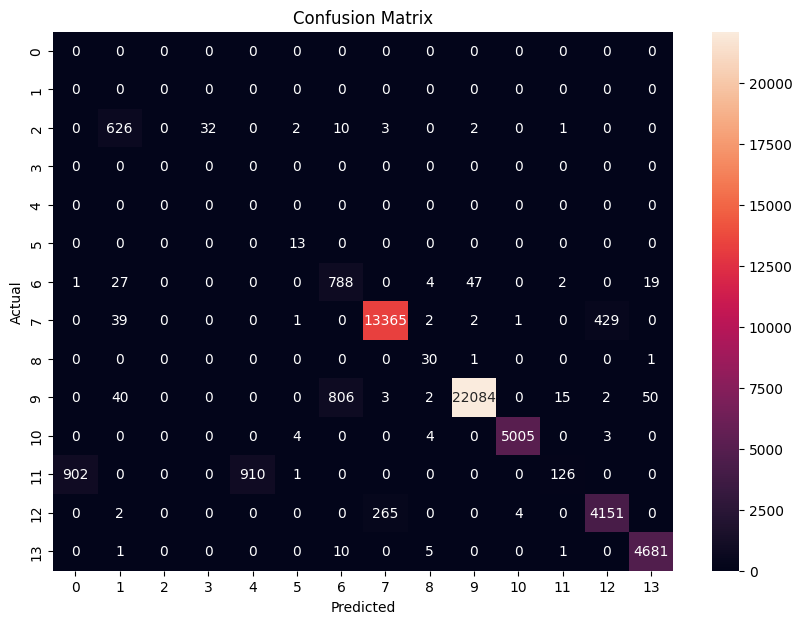

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()